**Importing the libraries**

In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra - data manipulation
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import datetime, warnings, scipy 

import seaborn as sns #visualization
import matplotlib as mpl #visualization
import matplotlib.pyplot as plt 


from collections import OrderedDict
from matplotlib.gridspec import GridSpec

from sklearn import metrics, linear_model #modelling
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit #modelling

pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

# Input data files are available in the "../input/" directory.


***DATA ANALYSIS***

In [53]:
df = pd.read_csv('../input/flight-delays/flights.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)

df_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
df_info=df_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
df_info=df_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
df_info

Dataframe dimensions: (5819079, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
null values (%),0,0,0,0,0,0,0.252978,0,0,0,1.48053,1.48053,1.53026,1.53026,0.000103109,1.80563,1.80563,0,1.58982,1.58982,0,1.58982,1.80563,0,0,98.4554,81.725,81.725,81.725,81.725,81.725


Given the large size of the dataset, we decided to consider only a subset of the data in order to reduce the computational time,just the flights from January 2015:

In [54]:
df = df[df['MONTH'] == 1]

The date contains year, month, day, hour, minute, second, and microsecond in the datetime module.

In [55]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

Function that convert the 'HHMM' string to datetime.time

In [56]:
def format_hour(chain):
    if pd.isnull(chain):
        return np.nan
    else:
        if chain == 2400: chain = 0
        chain = "{0:04d}".format(int(chain))
        hour = datetime.time(int(chain[0:2]), int(chain[2:4]))
        return hour

Function that combines a date and time to produce a datetime.datetime for merging the take-off hour with the flight date

In [57]:
def combine_date_hour(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])

Function that combine two columns of the dataframe to create a datetime format

In [58]:
def create_flight_time(df, col):    
    list = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            list.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            list.append(combine_date_hour(cols))
        else:
            cols[1] = format_hour(cols[1])
            list.append(combine_date_hour(cols))
    return pd.Series(list)

In [59]:

df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_hour)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_hour)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_hour)
#__________________________________________________________________________
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


***DATA CLEANING***

Only keeping the columns that are needed and dropoping the rest.

In [60]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


Examining the dataset

In [61]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)


,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,12955,97.243429
1,ELAPSED_TIME,12955,97.243429
2,ARRIVAL_TIME,12271,97.388971
3,DEPARTURE_TIME,11657,97.519618
4,DEPARTURE_DELAY,11657,97.519618
5,AIRLINE,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


In [62]:
df.dropna(inplace = True)


In [63]:
df.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


Retrieving full names of the airlines

In [64]:
airlines_names = pd.read_csv('../input/flight-delays/airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


For further use, we put the content of this dataframe in a dictionary:

In [65]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [66]:
print("Nb of airports: {}".format(len(df['ORIGIN_AIRPORT'].unique())))

Nb of airports: 312


Number of destination airports for each airline:

***DATA VISUALIZATION***

In [67]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    list_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(list_origin_airport)


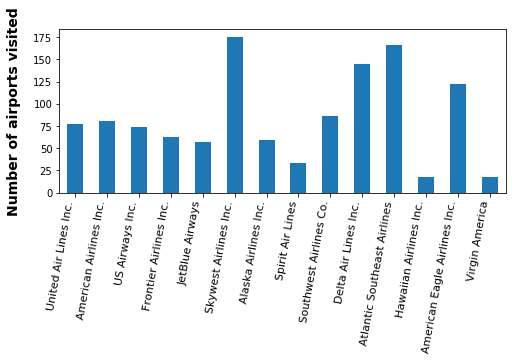

In [68]:

test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

Variations of the delays with respect to the origin airport and for every airline. 

The first step thus consists in determining the mean delays per airport:

In [79]:
temp = pd.read_csv('../input/flight-delays/airports.csv')
identify_airport = temp.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = temp.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = temp.set_index('IATA_CODE')['LONGITUDE'].to_dict()

Function that extract statistical parameters from a grouby objet:

In [75]:

def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}


Creation of a dataframe with statitical infos on each airline:

In [76]:

global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE,,,,
VX,-20.0,397.0,4647.0,6.896277
HA,-26.0,1003.0,6408.0,1.311954
F9,-32.0,696.0,6735.0,17.910765
NK,-28.0,557.0,8632.0,13.073100
AS,-47.0,444.0,13151.0,3.072086
B6,-27.0,500.0,20482.0,9.988331
MQ,-29.0,780.0,27568.0,15.995865
US,-26.0,638.0,32478.0,5.175011
UA,-40.0,886.0,37363.0,13.885555


In [77]:
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['AIRLINE'] == carrier]
    test = df1['DEPARTURE_DELAY'].groupby(df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean']

Since the number of airports is quite large, a graph showing all the information at once would be a bit messy, since it would represent around 4400 values (i.e. 312 airports  ×  14 airlines). Hence,just represented a subset of the data:

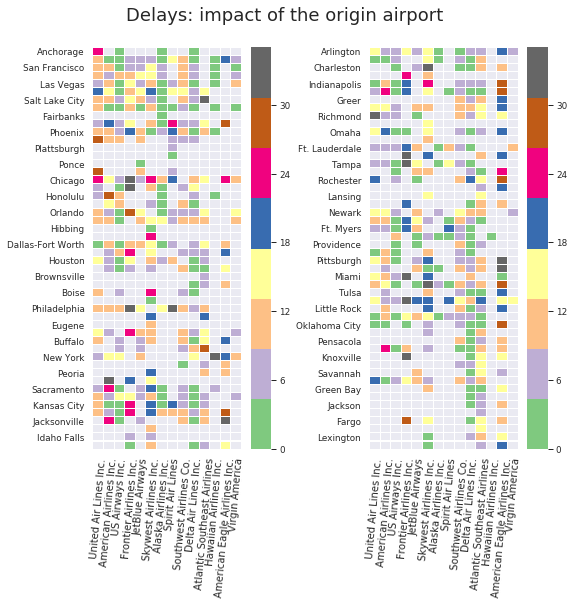

In [80]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

By looking at the data associated with the different airlines, we find the behavior we previously observed: consider the right panel, it will be seen that the column associated with American Eagle Airlines mostly reports large delays, while the column associated with Delta Airlines is mainly associated with delays of less than 5 minutes. If we now look at the airports of origin, we will see that some airports favor late departures: see e.g. Denver, Chicago or New York. Conversely, other airports will mainly know on time departures such as Portland or Oakland.

Finally, we can deduce from these observations that there is a high variability in average delays, both between the different airports but also between the different airlines. This is important because it implies that in order to accurately model the delays, it will be necessary to adopt a model that is specific to the company and the home airport .

In [81]:
#subset of the dataframe
carrier = 'AA'
df1 = df[df['AIRLINE']==carrier][['ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]

#  routes and list the delays for each of them
trajet = dict()
for ind, col in df1.iterrows():
    if pd.isnull(col['DEPARTURE_DELAY']): continue
    route = str(col['ORIGIN_AIRPORT'])+'-'+str(col['DESTINATION_AIRPORT'])
    if route in trajet.keys():
        trajet[route].append(col['DEPARTURE_DELAY'])
    else:
        trajet[route] = [col['DEPARTURE_DELAY']]
        
# transpose the dictionary in a list to sort the routes by origins        
list_trajet = []
for key, value in trajet.items():
    list_trajet.append([key, value])
list_trajet.sort()

average delay on the various paths A  →  B, as well as the standard deviation

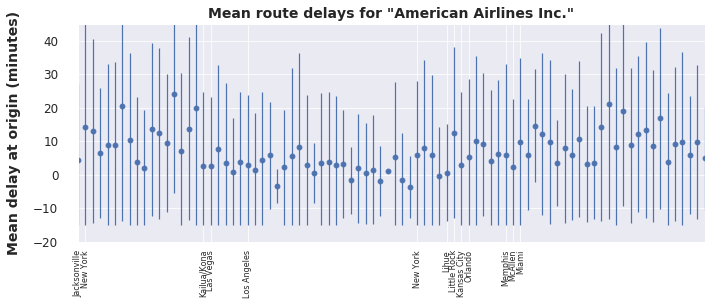

In [82]:
mean_val = [] ; std_val = [] ; x_label = []

i = 0
for route, list_retards in list_trajet:
    #_____________________________________________
    # set the labels as the airport from origin
    index = route.split('-')[0]
    x_label.append(identify_airport[index])
    #______________________________________________________________________________
    # put a threshold on delays to prevent that high values take too much weight
    trajet2 = [min(90, s) for s in list_retards]
    #________________________________________
    # compute mean and standard deviations
    mean_val.append(scipy.mean(trajet2))
    std_val.append(scipy.std(trajet2))
    i += 1
#________________
# Plot the graph
fig, ax = plt.subplots(figsize=(10,4))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)] 
ax.errorbar(list(range(i)), mean_val, yerr = [std_min, std_val], fmt='o') 
ax.set_title('Mean route delays for "{}"'.format(abbr_companies[carrier]),
             fontsize=14, weight = 'bold')
plt.ylabel('Mean delay at origin (minutes)', fontsize=14, weight = 'bold', labelpad=12)
#___________________________________________________
# define the x,y range and positions of the ticks
imin, imax = 145, 230
plt.xlim(imin, imax) ; plt.ylim(-20, 45)
list_ticks = [imin]
for j in range(imin+1,imax):
    if x_label[j] == x_label[j-1]: continue
    list_ticks.append(j)
#_____________________________
# and set the tick parameters  
ax.set_xticks(list_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()

The error bars associated with the different paths correspond to the standard deviations. In this example, it can be seen that for a given airport of origin, delays will fluctuate depending on the destination. We see, for example, that here the greatest variations are obtained for New York or Miami where the initial average delays vary between 0 and  ∼ 20 minutes.

***DATA MODELLING***

In [83]:
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]
df = df_train

In [84]:
def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
    
    # remove extreme values before fitting
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    
    # Conversion: date + hour -> hour
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['hour_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    
    # grouping of flights by departure time and averaging
    test2 = df2['DEPARTURE_DELAY'].groupby(df2['hour_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)
    
    
    # hour to second conversion
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    test2.reset_index(inplace=True)
    test2['hour_depart_min'] = test2['hour_depart'].apply(fct)
    return test2

In [86]:
def get_merged_delays(df, carrier):
    list_airports = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    i = 0
    list_columns = ['AIRPORT_ID', 'hour_depart_min', 'mean']
    for id_airport in list_airports:
        test2 = get_flight_delays(df, carrier, id_airport, True)
        test2.loc[:, 'AIRPORT_ID'] = id_airport
        test2 = test2[list_columns]
        test2.dropna(how = 'any', inplace = True)
        if i == 0:
            merged_df = test2.copy()
        else:
            merged_df = pd.concat([merged_df, test2], ignore_index = True)
        i += 1    
    return merged_df

In [87]:
carrier = 'AA'
merged_df = get_merged_delays(df, carrier)
merged_df.shape

(1831, 3)

In [88]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(merged_df['AIRPORT_ID'])

# correspondance between the codes and tags of the airports
zipped = zip(integer_encoded, merged_df['AIRPORT_ID'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
label_airports[:5]

[(0, 'ABQ'), (1, 'ATL'), (2, 'AUS'), (3, 'BDL'), (4, 'BHM')]

In [90]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
b = np.array(merged_df['hour_depart_min'])
b = b.reshape(len(b),1)
X = np.hstack((onehot_encoded, b))
Y = np.array(merged_df['mean'])
Y = Y.reshape(len(Y), 1)
print(X.shape, Y.shape)

(1831, 82) (1831, 1)


***LINEAR REGRESSION***

The matrices X and Y thus created can be used to perform a linear regression:

In [91]:
lm = linear_model.LinearRegression()
model = lm.fit(X,Y)
predictions = lm.predict(X)
print("MSE =", metrics.mean_squared_error(predictions, Y))

MSE = 53.74307365423858


number of predictions where the differences with real values is greater than 15 minutes

In [94]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-predictions[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(predictions) * 100)

'5.30%'

***POLYNOMIAL REGRESSION***

In [97]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X)
regr.fit(X_, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [98]:
result = regr.predict(X_)
print("MSE =", metrics.mean_squared_error(result, Y))

MSE = 49.50277343021948


We can see that a polynomial fit improves slightly the MSE score. In practice, the percentage of values where the difference between predictions and real delays is greater than 15 minutes is:

In [99]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-result[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(result) * 100)

'4.81%'

Two models were fit and tested on the training set.


SETTING THE FREE PARAMETERS

In [100]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [101]:
X_train.shape

(1281, 82)

In [103]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_train)
regr.fit(X_, Y_train)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_train)
print("Mean squared error = ", score)

Mean squared error =  45.8086947704417


Testing the test set

In [104]:
X_ = poly.fit_transform(X_test)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

Mean squared error =  11012370.31573016


Here, we see that the fit is particularly bad with a MSE > 500, which means that the fit performs poorly when generalyzing to other data. Now let's examine in detail the reasons why we have such a bad score. Below, I examing all the terms of the MSE calculation and identify the largest terms:

In [105]:
sum = 0
for values in zip(result, Y_test):
    add = (float(values[0]) - float(values[1]))**2
    sum += add
    if add > 10**4:
        print("{:<.1f} {:<.1f} {:<.1f}".format(add, float(values[0]), float(values[1])))

840172.5 -919.7 -3.1
816951685.5 28607.6 25.2
828937.8 -912.1 -1.7
2621208193.1 51197.4 -0.4
2616935002.2 51153.6 -2.4


We see that some predictions show very large errors. In practice, this can be explained by the fact that during the separation in train and test sets, data with no equivalent in the training set was put in the test data.


In [111]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0.3,normalize=True)
poly = PolynomialFeatures(degree = 2)
X_ = poly.fit_transform(X_train)
ridgereg.fit(X_, Y_train)

Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [112]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

Mean squared error =  67.90043005776312


In [113]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)        
        if score < score_min:
            score_min = score
            parameters = [alpha/10, pol_order]
        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha, score))

n=1 alpha=0 , MSE = 6.5561e+25
n=1 alpha=2 , MSE = 67.452
n=1 alpha=4 , MSE = 68.097
n=1 alpha=6 , MSE = 68.852
n=1 alpha=8 , MSE = 69.601
n=1 alpha=10 , MSE = 70.303
n=1 alpha=12 , MSE = 70.946
n=1 alpha=14 , MSE = 71.53
n=1 alpha=16 , MSE = 72.059
n=1 alpha=18 , MSE = 72.538
n=2 alpha=0 , MSE = 1789.1
n=2 alpha=2 , MSE = 67.896
n=2 alpha=4 , MSE = 67.975
n=2 alpha=6 , MSE = 68.201
n=2 alpha=8 , MSE = 68.469
n=2 alpha=10 , MSE = 68.756
n=2 alpha=12 , MSE = 69.049
n=2 alpha=14 , MSE = 69.343
n=2 alpha=16 , MSE = 69.634
n=2 alpha=18 , MSE = 69.918


In [114]:
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

54.16978704985709


***TESTING***

In [115]:
carrier = 'AA'
merged_df_test = get_merged_delays(df_test, carrier)

In [116]:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

merged_df_test['AIRPORT_ID'].replace(label_conversion, inplace = True)

for index, label in label_airports:
    temp = merged_df_test['AIRPORT_ID'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(merged_df_test['hour_depart_min'])
b = b.reshape(len(b),1)
X_test = np.hstack((matrix, b))
Y_test = np.array(merged_df_test['mean'])
Y_test = Y_test.reshape(len(Y_test), 1)

In [117]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
'MSE = {:.2f}'.format(score)

'MSE = 60.98'

This MSE score is equivalent to an average delay of:

In [118]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 7.81 min'

So,  the average difference in our predictions and actual delay is about 7.81 min